<a href="https://colab.research.google.com/github/mssanjay97/Project/blob/master/SETI%20signal%20classification%20my_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#install kaggle from google colab
!pip install kaggle


In [0]:
!mkdir .kaggle


In [0]:
#download dataset from kaggle
import json
token = {"username":"mssanjay","key":"63500b560696ce791d6ad3363a760246"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json


In [0]:
!kaggle config set -n path -v{/content}


- path is now set to: {/content}


In [0]:
!kaggle datasets download -d tentotheminus9/seti-data -p/content


100% 5.24G/5.25G [00:57<00:00, 109MB/s] 
100% 5.25G/5.25G [00:57<00:00, 98.5MB/s]


In [0]:
!unzip \*.zip

Archive:  seti-data.zip
  inflating: primary_small_v3.zip    
  inflating: primary_small.zip       


In [0]:
ls

primary_small_v3.zip  primary_small.zip  sample_data/  seti-data.zip


In [0]:
rm primary_small_v3.zip

In [0]:
ls

primary_small.zip  sample_data/  seti-data.zip


In [0]:
rm seti-data.zip

In [0]:
ls

primary_small.zip  sample_data/


In [0]:
!unzip \*.zip

Archive:  primary_small.zip
   creating: test/
   creating: test/brightpixel/
  inflating: test/brightpixel/1004_brightpixel.png  
 extracting: test/brightpixel/1056_brightpixel.png  
  inflating: test/brightpixel/1112_brightpixel.png  
  inflating: test/brightpixel/1128_brightpixel.png  
  inflating: test/brightpixel/1219_brightpixel.png  
  inflating: test/brightpixel/1293_brightpixel.png  
  inflating: test/brightpixel/1300_brightpixel.png  
  inflating: test/brightpixel/1301_brightpixel.png  
  inflating: test/brightpixel/1399_brightpixel.png  
 extracting: test/brightpixel/1401_brightpixel.png  
  inflating: test/brightpixel/1411_brightpixel.png  
  inflating: test/brightpixel/1469_brightpixel.png  
 extracting: test/brightpixel/1499_brightpixel.png  
 extracting: test/brightpixel/1535_brightpixel.png  
  inflating: test/brightpixel/1650_brightpixel.png  
 extracting: test/brightpixel/1651_brightpixel.png  
  inflating: test/brightpixel/174_brightpixel.png  
  inflating: test/brig

In [0]:
#import library
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [0]:
#function to preprocess image.
def pp(img,gray=False):
  #resize image to fixed common size and convert everything to grayscale 
    img = cv2.resize(img, (224, 224))
    if gray:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #remove pixeld that are away from mean pixel value   
    mean = np.mean(img)
    std = np.std(img)
    imag = np.clip(img, mean-3.5*std, mean+3.5*std)
    #apply image closing 
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel=np.ones((3, 3), dtype=np.float32))
    #detect edge using sobel operator 
    x = cv2.Sobel(img, cv2.CV_64F, 1, 0, 2)
    y = cv2.Sobel(img, cv2.CV_64F, 0, 1, 2)
    img = cv2.addWeighted(src1=x, alpha=0.7, src2=y, beta=0.3, gamma=0)
    img = img.reshape(224, 224, 1)
    #normalise image 
    img = img/255
    return img

In [0]:
from keras.preprocessing.image import ImageDataGenerator
#increase dataset by generating image from existing ones. techniques like scaling,inversion,rotation and translation are used. 
train_gen=ImageDataGenerator(width_shift_range=0.01,
                                 height_shift_range=0.01,
                                 zoom_range=0.01,
                                 shear_range=0.01,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 preprocessing_function=pp,
                                 rotation_range=3.0)

Using TensorFlow backend.


In [0]:
import os
import itertools
import time
#read data from directory 
train=train_gen.flow_from_directory(directory=os.path.join("train"),target_size=(224,224),batch_size=50,color_mode="grayscale")

Found 5600 images belonging to 7 classes.


In [0]:
#numpy array to store test image dataset
x_test = np.empty(shape=(0,224,224,1))
y_test = np.empty(shape=(0,))

In [0]:
#read testing image dataset belonging to 7 classes. 
for c in ["brightpixel","narrowband","narrowbanddrd","noise","squarepulsednarrowband","squiggle","squigglesquarepulsednarrowband"]:
  dir = os.path.join("test", c)
  temx=[]
  temy=[]
  for idx, file in enumerate(os.listdir(dir)):
    #read image
    im = cv2.imread(os.path.join(dir, file))
    #apply preprocessing 
    im = pp(im,True)
    #append it to list
    temx.insert(idx,im)
    temy.insert(idx,c)
  #convert list to array
  temx=np.array(temx)
  temy=np.array(temy)
  x_test=np.append(x_test,temx,axis=0)
  y_test=np.append(y_test,temy,axis=0)
    

In [0]:
#numpy array to store validation image dataset

x_valid = np.empty(shape=(0,224,224,1))
y_valid = np.empty(shape=(0,))

In [0]:
#read validation image dataset belonging to 7 classes. 

for c in ["brightpixel","narrowband","narrowbanddrd","noise","squarepulsednarrowband","squiggle","squigglesquarepulsednarrowband"]:
  dir = os.path.join("valid", c)
  temx=[]
  temy=[]
  for idx, file in enumerate(os.listdir(dir)):
    #read image
    im = cv2.imread(os.path.join(dir, file))
    #apply preprocessing
    im = pp(im,True)
    #append it to list
    temx.insert(idx,im)
    temy.insert(idx,c)
  temx=np.array(temx)
  temy=np.array(temy)
  x_valid=np.append(x_test,temx,axis=0)
  y_valid=np.append(y_test,temy,axis=0)

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
#convert output class to one hot vector encoding form
enc = LabelEncoder()
enc.fit(y_test)
enc = enc.transform(y_test)
y_test = to_categorical(enc,7)
y_test = np.argmax(y_test, axis=1)

In [0]:
#convert output class to one hot vector encoding form
enc = LabelEncoder()
enc.fit(y_valid)
enc = enc.transform(y_valid)
y_valid = to_categorical(enc,7)
#y_valid = np.argmax(y_valid, axis=1)

In [0]:
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.layers import Dense, LeakyReLU, Flatten, Dropout,Activation,Input,BatchNormalization,GlobalAveragePooling2D,Concatenate,concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D,SeparableConv2D

In [0]:
#defining convolutional neural network 
img_input = Input(shape=(224,224,1))
#add 32 3x3 convolutional layer with stride 2 pixels 
x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(img_input)
#apply batch noramlisation 
x = BatchNormalization(name='block1_conv1_bn')(x)
#add relu layer
x = Activation('relu', name='block1_conv1_act')(x)
#add 64 3x3 convolutional layer 
x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
#apply batch noramlisation 
x = BatchNormalization(name='block1_conv2_bn')(x)
#add relu layer
x = Activation('relu', name='block1_conv2_act')(x)
#add 128 1x1 convolutional layer 
residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
#apply batch noramlisation 
residual = BatchNormalization()(residual)
#add 128 3x3 convolutional layer
x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
#apply batch noramlisation
x = BatchNormalization(name='block2_sepconv1_bn')(x)
#add relu layer
x = Activation('relu', name='block2_sepconv2_act')(x)
x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
#apply batch noramlisation
x = BatchNormalization(name='block2_sepconv2_bn')(x)

x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
#combine 2 layers in to 1 layer 
x = concatenate([x, residual])

residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = Activation('relu', name='block3_sepconv1_act')(x)
x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
x = BatchNormalization(name='block3_sepconv1_bn')(x)
x = Activation('relu', name='block3_sepconv2_act')(x)
x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
x = BatchNormalization(name='block3_sepconv2_bn')(x)
x = Activation('relu', name='block3_sepconv3_act')(x)
x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv3')(x)
x = BatchNormalization(name='block3_sepconv3_bn')(x)
x = Activation('relu', name='block3_sepconv4_act')(x)
x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv4')(x)
x = BatchNormalization(name='block3_sepconv4_bn')(x)



x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
x = concatenate([x, residual])

residual = Conv2D(728, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = Activation('relu', name='block4_sepconv1_act')(x)
x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
x = BatchNormalization(name='block4_sepconv1_bn')(x)
x = Activation('relu', name='block4_sepconv2_act')(x)
x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
x = BatchNormalization(name='block4_sepconv2_bn')(x)
x = Activation('relu', name='block4_sepconv3_act')(x)
x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv3')(x)
x = BatchNormalization(name='block4_sepconv3_bn')(x)



x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
x = concatenate([x, residual])

for i in range(1):
    residual = x
    prefix = 'block' + str(i + 5)

    x = Activation('relu', name=prefix + '_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
    x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
    x = Activation('relu', name=prefix + '_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
    x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
 

    x = concatenate([x, residual])

residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = Activation('relu', name='block13_sepconv1_act')(x)
x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
x = BatchNormalization(name='block13_sepconv1_bn')(x)

x = Activation('relu', name='block13_sepconv2_act')(x)
x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
x = BatchNormalization(name='block13_sepconv2_bn')(x)


x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
x = concatenate([x, residual])

x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
x = BatchNormalization(name='block14_sepconv1_bn')(x)
x = Activation('relu', name='block14_sepconv1_act')(x)

x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
x = BatchNormalization(name='block14_sepconv2_bn')(x)
x = Activation('relu', name='block14_sepconv2_act')(x)


x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(7, activation='softmax', name='predictions')(x)
    

model = Model(img_input, x, name='xception')


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [0]:
#set learning rate and optimisation function 
opt=Adam(lr=0.0015)
#compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

In [0]:
#train model
his = model.fit_generator(train,epochs=30,steps_per_epoch=100,validation_data=(x_valid, y_valid),shuffle=True,verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 213s 2s/step - loss: 1.4224 - acc: 0.4624 - val_loss: 11.4892 - val_acc: 0.1550
Epoch 2/30
100/100 [==============================] - 201s 2s/step - loss: 1.1047 - acc: 0.5774 - val_loss: 9.1661 - val_acc: 0.2275
Epoch 3/30
100/100 [==============================] - 201s 2s/step - loss: 0.9593 - acc: 0.6296 - val_loss: 5.9487 - val_acc: 0.3975
Epoch 4/30
100/100 [==============================] - 201s 2s/step - loss: 0.9509 - acc: 0.6434 - val_loss: 10.1231 - val_acc: 0.2063
Epoch 5/30
100/100 [==============================] - 201s 2s/step - loss: 0.8621 - acc: 0.6714 - val_loss: 1.2828 - val_acc: 0.6475
Epoch 6/30
100/100 [==============================] - 201s 2s/step - loss: 0.8452 - acc: 0.6804 - val_loss: 2.0645 - val_acc: 0.5388
Epoch 7/30
100/100 [==============================] - 200s 2s/step - loss: 0.7936 - acc: 0.7100 - val_loss: 2.4078 - val_acc: 0.4550
Epoch 8/30
100/100 

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

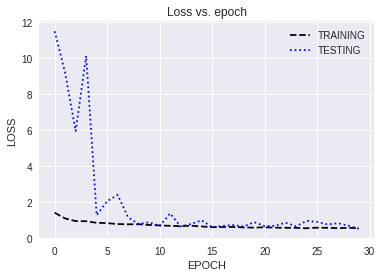

In [0]:
#plot loss vvs epoch graph 
plt.plot(his.history['loss'],'--k')
plt.plot(his.history['val_loss'],':b')
plt.title('Loss vs. epoch')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'TESTING'], loc='best')


plt.show()

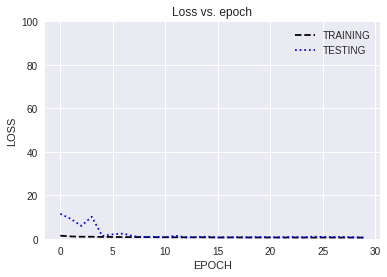

In [0]:
plt.plot(his.history['loss'],'--k')
plt.plot(his.history['val_loss'],':b')
plt.title('Loss vs. epoch')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'TESTING'], loc='best')
axes = plt.gca()
axes.set_ylim([0,100])

plt.show()

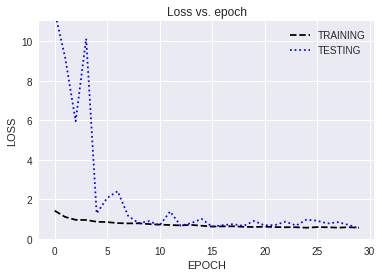

In [0]:
plt.plot(his.history['loss'],'--k')
plt.plot(his.history['val_loss'],':b')
plt.title('Loss vs. epoch')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'TESTING'], loc='best')
axes = plt.gca()
axes.set_ylim([0,11])

plt.show()

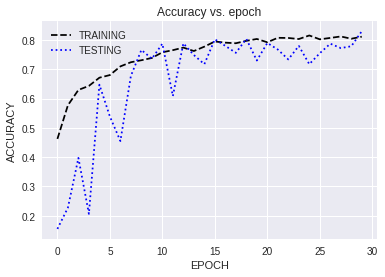

In [0]:
plt.plot(his.history['acc'],'--k')
plt.plot(his.history['val_acc'],':b')
plt.title('Accuracy vs. epoch')
plt.ylabel('ACCURACY')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'TESTING'], loc='best')

plt.show()

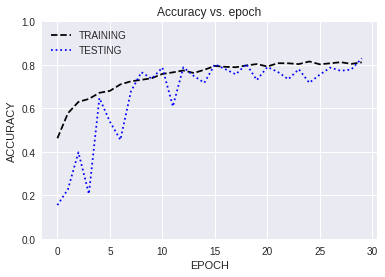

In [0]:
plt.plot(his.history['acc'],'--k')
plt.plot(his.history['val_acc'],':b')
plt.title('Accuracy vs. epoch')
plt.ylabel('ACCURACY')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'TESTING'], loc='best')
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

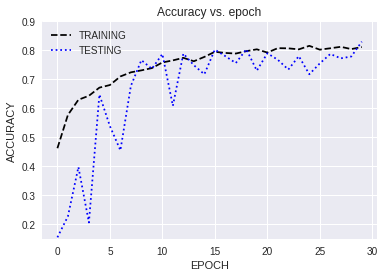

In [0]:
plt.plot(his.history['acc'],'--k')
plt.plot(his.history['val_acc'],':b')
plt.title('Accuracy vs. epoch')
plt.ylabel('ACCURACY')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'TESTING'], loc='best')
axes = plt.gca()
axes.set_ylim([0.15,0.9])
plt.show()

In [0]:
from keras.models import load_model
model.save('mynet1.h5')
model = load_model('mynet1.h5')
from google.colab import files
files.download('mynet1.h5') 

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 39198, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

KeyboardInterrupt: ignored

In [0]:
import pickle

f = open('his_mynet1.pckl', 'wb')
pickle.dump(his, f)
f.close()

f = open('his_mynet1.pckl', 'rb')
his = pickle.load(f)
f.close()

files.download('his_mynet1.pckl') 

KeyboardInterrupt: ignored

In [0]:
y_hat = model.predict(x_test)
y_hat=np.argmax(y_hat,axis=1)

In [0]:
print("Classification Report")
print(classification_report(y_test, y_hat, digits=5))

Classification Report
              precision    recall  f1-score   support

           0    0.83333   0.80000   0.81633       100
           1    0.81982   0.91000   0.86256       100
           2    0.89655   0.78000   0.83422       100
           3    0.68644   0.81000   0.74312       100
           4    0.96774   0.60000   0.74074       100
           5    0.90385   0.94000   0.92157       100
           6    0.76230   0.93000   0.83784       100

   micro avg    0.82429   0.82429   0.82429       700
   macro avg    0.83858   0.82429   0.82234       700
weighted avg    0.83858   0.82429   0.82234       700



In [0]:
print("ACCURACY:",(accuracy_score(y_test, y_hat)))

ACCURACY: 0.8242857142857143
